In [1]:
import os

titanic_path = os.path.join('dataset')

In [2]:
import pandas as pd

def load_titanic_data(filename, titanic_path = titanic_path):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [3]:
train_data = load_titanic_data('train.csv')
test_data = load_titanic_data('test.csv')

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [8]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [9]:
# note: remember to compute the median for the age for imputation
train_data['Age'].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

In [10]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [11]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [12]:
corr_matrix = train_data.corr()

In [13]:
corr_matrix['Survived'].sort_values(ascending = False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [16]:
num_pipeline.fit_transform(train_data)


array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [17]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [20]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [21]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [22]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [23]:
y_train = train_data["Survived"]

In [24]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [25]:
y_pred = svm_clf.predict(X_train)

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [27]:
accuracy_score(y_train, y_pred)

0.8877665544332211

In [28]:
precision_score(y_train, y_pred)

0.8734567901234568

In [29]:
recall_score(y_train, y_pred)

0.827485380116959

In [30]:
f1_score(y_train, y_pred)

0.8498498498498498

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, reciprocal

In [33]:
param_grids = [{'C' : uniform(0.1, 1), 'gamma' : uniform(0.1, 1)}]
random_search = RandomizedSearchCV(svm_clf, param_grids, n_iter = 10, scoring = 'accuracy', verbose = 3)

In [34]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=0.3345020756127721, gamma=0.9700116295497566 ..................
[CV]  C=0.3345020756127721, gamma=0.9700116295497566, score=0.642, total=   0.0s
[CV] C=0.3345020756127721, gamma=0.9700116295497566 ..................
[CV]  C=0.3345020756127721, gamma=0.9700116295497566, score=0.624, total=   0.0s
[CV] C=0.3345020756127721, gamma=0.9700116295497566 ..................
[CV]  C=0.3345020756127721, gamma=0.9700116295497566, score=0.629, total=   0.0s
[CV] C=0.3345020756127721, gamma=0.9700116295497566 ..................
[CV]  C=0.3345020756127721, gamma=0.9700116295497566, score=0.629, total=   0.0s
[CV] C=0.3345020756127721, gamma=0.9700116295497566 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  C=0.3345020756127721, gamma=0.9700116295497566, score=0.618, total=   0.0s
[CV] C=0.5924236594430722, gamma=0.3080002166988146 ..................
[CV]  C=0.5924236594430722, gamma=0.3080002166988146, score=0.659, total=   0.0s
[CV] C=0.5924236594430722, gamma=0.3080002166988146 ..................
[CV]  C=0.5924236594430722, gamma=0.3080002166988146, score=0.635, total=   0.0s
[CV] C=0.5924236594430722, gamma=0.3080002166988146 ..................
[CV]  C=0.5924236594430722, gamma=0.3080002166988146, score=0.697, total=   0.0s
[CV] C=0.5924236594430722, gamma=0.3080002166988146 ..................
[CV]  C=0.5924236594430722, gamma=0.3080002166988146, score=0.691, total=   0.0s
[CV] C=0.5924236594430722, gamma=0.3080002166988146 ..................
[CV]  C=0.5924236594430722, gamma=0.3080002166988146, score=0.612, total=   0.0s
[CV] C=0.7046488384435511, gamma=1.0351292582989915 ..................
[CV]  C=0.7046488384435511, gamma=1.0351292582989915, score=0.659, total=   0.0s
[CV] C=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.7s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='auto', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f49122e8668>,
                                         'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f49122e86a0>}],
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=3)

In [35]:
y_prediction = random_search.best_estimator_.predict(X_train)

In [36]:
accuracy_score(y_train, y_prediction)

0.9562289562289562

In [37]:
precision_score(y_train, y_prediction)

0.9779179810725552

In [38]:
recall_score(y_train, y_prediction)

0.9064327485380117

In [39]:
f1_score(y_train, y_prediction)

0.9408194233687405

In [40]:
from mlxtend.plotting import plot_confusion_matrix

In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

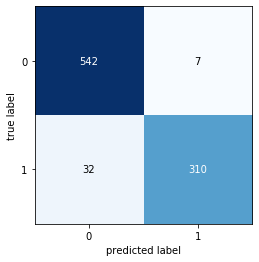

In [46]:
conf_mat = confusion_matrix(y_train,  y_prediction)
plot_confusion_matrix(conf_mat)
plt.show()

In [56]:
false_negatives = train_data.loc[(y_train == 1) & (y_prediction == 0)] # people we incorrectly said died even though they didn't

In [60]:
false_negatives['Pclass'].value_counts()

3    25
2     4
1     3
Name: Pclass, dtype: int64

In [61]:
false_negatives['Age'].value_counts()

32.0    3
31.0    2
19.0    2
18.0    2
45.0    2
24.0    2
29.0    2
15.0    1
22.0    1
28.0    1
44.0    1
39.0    1
21.0    1
25.0    1
16.0    1
34.0    1
Name: Age, dtype: int64

In [62]:
false_negatives['Sex'].value_counts()

male      28
female     4
Name: Sex, dtype: int64

In [64]:
false_negatives['Embarked'].value_counts()

S    27
C     4
Q     1
Name: Embarked, dtype: int64

In [66]:
false_negatives.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,32.000000,32.0,32.000000,24.000000,32.000000,32.0,32.000000
mean,405.687500,1.0,2.687500,28.000000,0.062500,0.0,13.461847
std,248.138026,0.0,0.644455,8.992751,0.245935,0.0,12.584515
min,18.000000,1.0,1.000000,15.000000,0.000000,0.0,7.141700
25%,217.000000,1.0,3.000000,20.500000,0.000000,0.0,7.839600
50%,408.000000,1.0,3.000000,28.500000,0.000000,0.0,8.050000
75%,572.500000,1.0,3.000000,32.000000,0.000000,0.0,13.000000
max,831.000000,1.0,3.000000,45.000000,1.000000,0.0,56.495800


In [67]:
true_positives = train_data.loc[(y_train == 1) & (y_prediction == 1)] # those that did survived

In [70]:
true_positives['Sex'].value_counts()

female    229
male       81
Name: Sex, dtype: int64

In [76]:
true_positives['Pclass'].value_counts()

1    133
3     94
2     83
Name: Pclass, dtype: int64

In [77]:
X_test = preprocess_pipeline.transform(test_data)
y_pred =  random_search.best_estimator_.predict(X_test)

In [78]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(random_search.best_estimator_, X_train, y_train, cv = 10)
svm_scores.mean()

0.667765293383271

In [79]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv = 10)
forest_scores.mean()

0.8126466916354558